Using cpu device
CNN(
  (hidden1): Linear(in_features=3072, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=512, bias=True)
  (hidden3): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


 10%|█         | 1/10 [00:38<05:45, 38.42s/it]

Epoch 1:	 Train accuracy: 40.9%	 Avg train loss: 1.663636	 Test accuracy: 46.7%	 Avg test loss: 1.511945


 20%|██        | 2/10 [01:21<05:26, 40.87s/it]

Epoch 2:	 Train accuracy: 49.1%	 Avg train loss: 1.438369	 Test accuracy: 48.3%	 Avg test loss: 1.447166


 30%|███       | 3/10 [02:05<04:56, 42.43s/it]

Epoch 3:	 Train accuracy: 52.9%	 Avg train loss: 1.319802	 Test accuracy: 51.7%	 Avg test loss: 1.375890


 40%|████      | 4/10 [02:47<04:14, 42.34s/it]

Epoch 4:	 Train accuracy: 56.7%	 Avg train loss: 1.221685	 Test accuracy: 52.1%	 Avg test loss: 1.373427


 50%|█████     | 5/10 [03:29<03:30, 42.16s/it]

Epoch 5:	 Train accuracy: 59.5%	 Avg train loss: 1.137213	 Test accuracy: 53.4%	 Avg test loss: 1.364971


 60%|██████    | 6/10 [04:12<02:49, 42.42s/it]

Epoch 6:	 Train accuracy: 62.3%	 Avg train loss: 1.051232	 Test accuracy: 53.5%	 Avg test loss: 1.381136


 70%|███████   | 7/10 [04:56<02:09, 43.06s/it]

Epoch 7:	 Train accuracy: 65.0%	 Avg train loss: 0.971579	 Test accuracy: 53.4%	 Avg test loss: 1.436112


 80%|████████  | 8/10 [05:38<01:25, 42.81s/it]

Epoch 8:	 Train accuracy: 67.8%	 Avg train loss: 0.898421	 Test accuracy: 53.6%	 Avg test loss: 1.461460


 90%|█████████ | 9/10 [06:21<00:42, 42.64s/it]

Epoch 9:	 Train accuracy: 70.3%	 Avg train loss: 0.826475	 Test accuracy: 54.4%	 Avg test loss: 1.508312


100%|██████████| 10/10 [07:03<00:00, 42.37s/it]

Epoch 10:	 Train accuracy: 72.6%	 Avg train loss: 0.754900	 Test accuracy: 53.8%	 Avg test loss: 1.569834


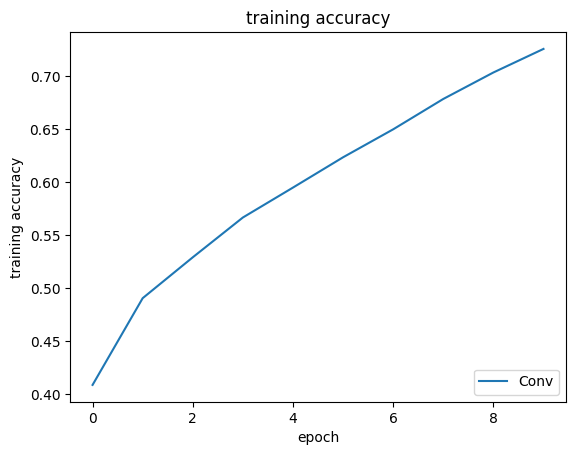

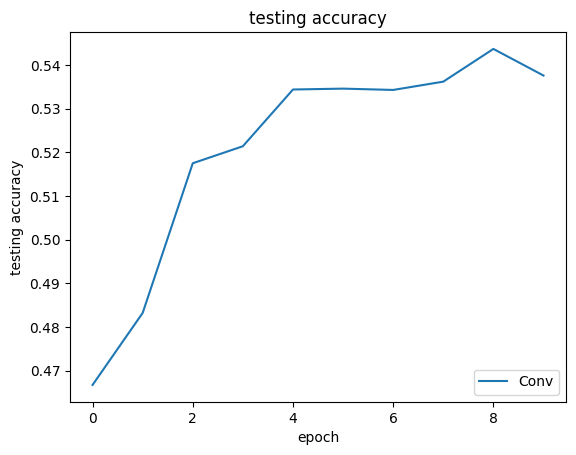

In [21]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3*32*32, 512, device=device)
        self.hidden2 = nn.Linear(512, 512, device=device)
        self.hidden3 = nn.Linear(512, 512, device=device)
        self.output = nn.Linear(512, 10, device=device)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.log_softmax(self.output(x), 1)
        return x

model = CNN().to(device)
print(model)

#negative log likelihood loss
loss_fn = nn.NLLLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

epochs = 10
all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(epochs)):

    # train
    train_accuracy, average_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    all_train_accuracies += [train_accuracy]

    #test
    test_accuracy, average_test_loss = test(test_dataloader, model, loss_fn)
    all_test_accuracies += [test_accuracy]

    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


plt.plot(all_train_accuracies)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies)
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='lower right')
plt.show()